# Histopathologic Cancer Detection
### Mini Project for DTSA 5511: Introduction to Deep Learning
#### University of Colorado, Boulder - Master of Science in Data Science

**By:** Andrea Francu  
**Version:** 1.0  
**Date:** Februay 2, 2025

This project is created for the Histopathologic Cancer Detection Kaggle competition (https://www.kaggle.com/c/histopathologic-cancer-detection/overview). The goal of this project is to create and train a model that can identify metastatic cancer in small image patches from digital pathology scans. The data that accompanies this competition consists of a csv of training labels, a csv of a sample submission, and a test folder and train folder. Each of those folders contains tens to hundreds of thousands of images from these pathology scans, in .tif format.

Load in the necessary libraries

In [37]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import random
import shutil
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import AUC

Project is run in Google Colab, in order to access the use of GPU's Mount drive to access data and import the image and label data.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Data First Look
We can now load in the different datasets and get a look at how many images are in the test and train datasets, and a look at what the train labels look like.

In [3]:
# unzip test/train data file - only needs to be done once
# !unzip /content/drive/My\ Drive/cancer-detection/histopathologic-cancer-detection.zip -d /content/drive/My\ Drive/cancer-detection/histopathologic-cancer-detection/

# directory of test and train data
base_dir = Path('/content/drive/My Drive/cancer-detection/histopathologic-cancer-detection')
train_full_dir = base_dir / 'train'
test_full_dir = base_dir / 'test'
train_labels_dir = base_dir / 'train_labels.csv'

# load in the train data labels
train_labels = pd.read_csv(train_labels_dir)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
# number of files in train and test folders
print(f"Number of files in train data set: {len(os.listdir(train_full_dir))}")
print(f"Number of files in test data set: {len(os.listdir(test_full_dir))}")

Number of files in test data set: 57458


The train labels assign a 1 to images with at least one pixel of tumor tissue, and 0 to those without. The train data set contains 220,025 files and the test data set contains 57,458. For the sake of run time to enable quick iterations, and GPU availability, I've decided to use a smaller subset of the training data. The subset for the training data is balanced, with an equal number of cancer vs. non cancer images - 5,000 of each.

In [8]:
# separate folders by labels
non_cancer_img = train_labels[train_labels['label'] == 0]['id'].tolist()
cancer_img = train_labels[train_labels['label'] == 1]['id'].tolist()

# 10,000 random samples from each class
non_cancer_samples = random.sample(non_cancer_img, 5000)
cancer_samples = random.sample(cancer_img, 5000)

# function for copying images into new directory
def copy_images(image_list, label, source_dir, dest_dir):
    source_dir = Path(source_dir)
    label_dir = Path(dest_dir) / str(label)

    # create the label directory if it doesn't exist
    label_dir.mkdir(parents=True, exist_ok=True)

    for image_name in image_list:
        src_path = source_dir / f"{image_name}.tif"
        dest_path = label_dir / f"{image_name}.tif"

        if src_path.exists():
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found, skipping: {src_path}")

# copy subset images to new directory - only needs to be done once
train_dir = base_dir / 'train_subset'
# copy_images(non_cancer_samples, 0, train_full_dir, train_dir)
# copy_images(cancer_samples, 1, train_full_dir, train_dir)

In [9]:
# rescale image pixel values from 0-255 to 0-1, and split some data for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Exploratory Data Analysis (EDA)

Once the training data is saved off, this can be loaded in to train and validation data, and we can start to create some visualizations.

In [10]:
# load data, using folder directory names (0 and 1) as class labels
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

Found 8000 images belonging to 2 classes.


In [11]:
# do the same for validation data
val_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 2000 images belonging to 2 classes.


In [106]:
# do the same for test data, without the class labels since there won't be any
test_data_gen = datagen.flow_from_directory(
    test_full_dir,
    target_size=(224, 224),
    batch_size=512,
    class_mode=None,
    shuffle=False) # keep the order the same

Found 57458 images belonging to 1 classes.


One easy visualization we can use is simply looking at samples of the trianing data and what label they are assigned.

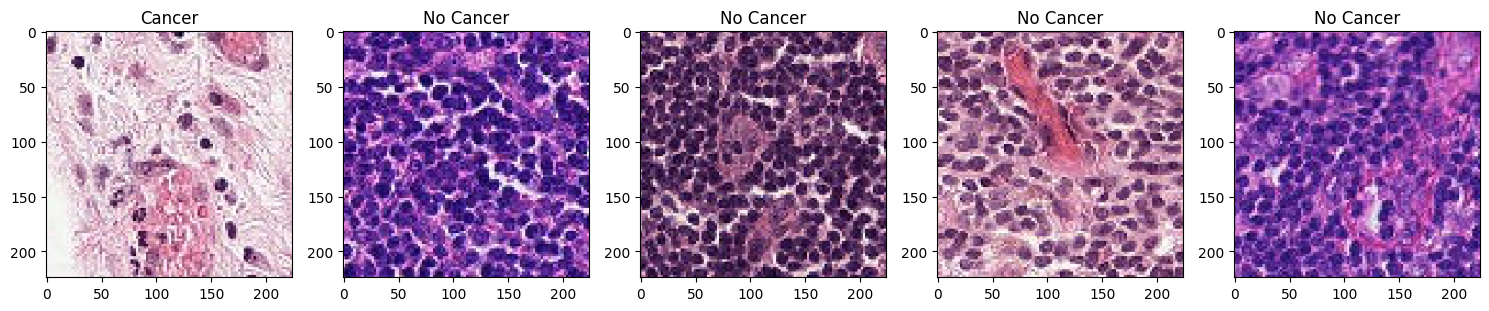

In [12]:
# function to display some sample images from both classes
def sample_images():
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img, label = next(train_data_gen)
        ax.imshow(img[0])
        ax.set_title('Cancer' if label[0] == 1 else 'No Cancer')
    plt.tight_layout()
    plt.show()

sample_images()

As you can see, it is pretty hard to pinpoint what features distinguish between cancer and no cancer with just the human eye. There is also an extremely large amount of data, that would take humans years to get through what a computer can do in hours. This makes tasks like these perfect for machine learning.

We can now take a look at the class distribution, which should be even for the subset of data we extracted. This class balance will ensure greater accuracy for our model. However, consideration does need to be taken to account for the small dataset that's being used for training, to avoid overfitting.

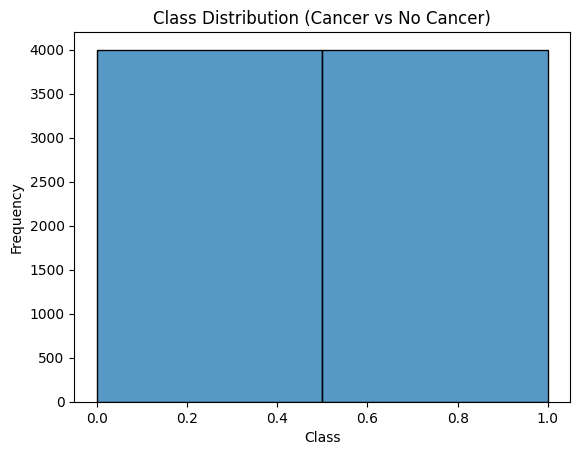

In [13]:
def class_distribution():
    class_labels = train_data_gen.classes
    fig, ax = plt.subplots()
    sns.histplot(class_labels, kde=False, bins=2, ax=ax)
    ax.set_title('Class Distribution (Cancer vs No Cancer)')
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    plt.show()

class_distribution()

## Model Architecture

I initially tried to build a simple CNN model from scratch, but this resulted in a very long runtime, an estimated 15 hours to train my model. Due to my limited GPU access, I decided to use a few methods to cut down this training time, to also allow for a bit of fine tuning.

So I decided to instead use transfer learning to leverage an existing model. The base model I used is MobileNetV2, a popular CNN architecture for transfer learning. I then built on top of this base model by freezing the weights, so there would be no retraining, and adding some more layers. I first added an average pooling layer from the output of the base model to reduce output dimensions and allow the model to generalize better. I then added a dense layer with a ReLu activation function to allow the model to learn complex patterns. I then added a dropout layer to avoid overfitting since the dataset is fairly small, and a final dense layer with sigmoid activation to give a probability between 0 and 1.

I implemented a few other methods to speed up training time. I used early stopping by monitoring the validation loss and stopping the model early once it stops improving. I also added a learning rate scheduler. This just specifies one learning rate for the first few epochs, and then a faster rate for the later ones. All these steps combined allowed me to train my model much faster that my initial attempt.

In [47]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze the base model's weights

In [50]:
model = tf.keras.Sequential([
    base_model,  # pre-trained MobileNetV2 model
    tf.keras.layers.GlobalAveragePooling2D(), # average pooling layer
    tf.keras.layers.Dense(128, activation='relu'),  # dense layer with relu
    tf.keras.layers.Dropout(0.5),  # dropout for regularization to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # final layer for binary classification
])

In [51]:
# use AUC as metric since the Kaggle competition uses this metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

In [52]:
# add early stopping to monitor validation loss and stop training once it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [53]:
# use a learning rate schedule to speed up training after certain number of epochs
def lr_schedule(epoch):
    if epoch < 4:
        return 0.001  # initial learning rate
    else:
        return 0.0001  # reduced learning rate after 4 epochs

lr_scheduler = LearningRateScheduler(lr_schedule)

In [42]:
history = model.fit(
    train_data_gen,
    epochs=6,
    validation_data=val_data_gen,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - auc: 0.8084 - loss: 0.5499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 1103s 4s/step - auc: 0.8087 - loss: 0.5496 - val_auc: 0.9064 - val_loss: 0.3875 - learning_rate: 0.0010
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - auc: 0.9007 - loss: 0.3972 - val_auc: 0.9125 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - auc: 0.9058 - loss: 0.3872 - val_auc: 0.9127 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - auc: 0.9107 - loss: 0.3789 - val_auc: 0.9100 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - auc: 0.9251 - loss: 0.3488 - val_auc: 0.9176 - val_loss: 0.3651 - learning_rate: 1.0000e-04
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - auc: 0.9327 - loss: 0.3315 - val_auc: 0.9184 - val_loss: 0.3648 - learning_rate: 1.0000e-04


Now that the first model is trained, we can take a look at some metrics to inform our fine tuning steps. We can asses if we have any overfitting or underfitting by looking at AUC of both our train and validation data.

The training AUC appears to increase greatly in the first to second epoch, and then gradually increase each epoch. The validation AUC also appears to go up gradually, with one minor drop in epoch 4 but then it came back up. This indicates that the model can generalize well and there is no significant overfitting, which is good considering the small subset of the original data that was used.

The loss appears to gradually decrease for both train and validation data, with a minor blip at epoch 4 for the validation again. This indicates that the model is lowering its loss well, and the model is converging well.

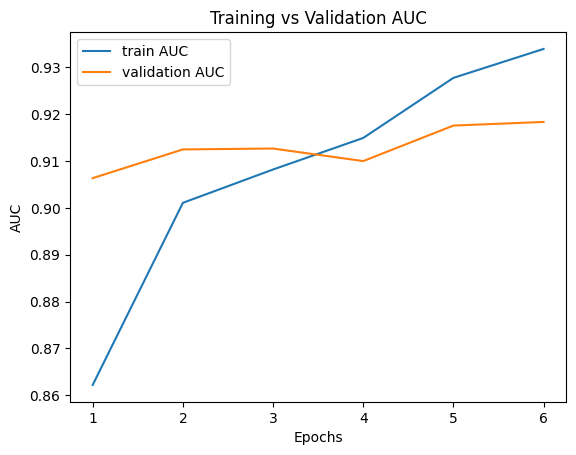

In [76]:
# plot comparison of train vs validation AUC of first model
epochs = range(1, len(history.history['auc']) + 1)

plt.plot(epochs, history.history['auc'], label='train AUC')
plt.plot(epochs, history.history['val_auc'], label='validation AUC')
plt.legend()
plt.title('Training vs Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.show()

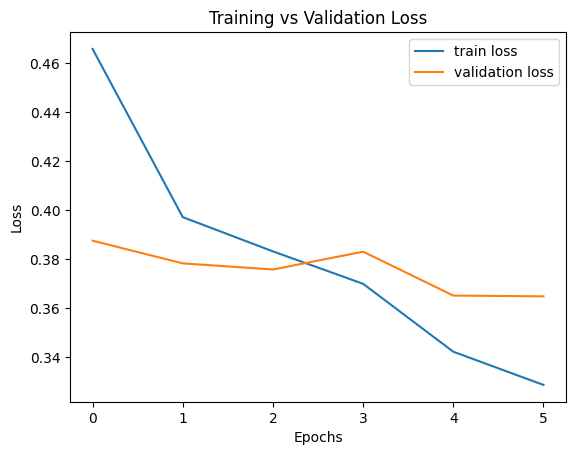

In [60]:
# plot comparison of train vs validation loss of first model
epochs = range(1, len(history.history['auc']) + 1)

plt.plot(epochs, history.history['auc'], label='train AUC')
plt.plot(epochs, history.history['val_auc'], label='validation AUC')
plt.legend()
plt.title('Training vs Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.show()

## Hyperparameter Tuning
Now that I have my first model, which is already fairly good, I can try fine tuning some of the hyperparameters. I don't want to make too large of changes, as the model is already performing well, but there are a few hyperparameters I can tune a bit.

I first adjusted my learning rate scheduler, to start at a lower learning rate for smoother convergence. I then lower my dropout layer to 0.3 instead of 0.5 to retain more information, since my model was already pretty good at generalizing. Then I increase the number of epochs, since it looks like the first model was still improving at the end of the last epoch. And I increased my batch size for faster training, since some of the other parameters I tuned may slow down the trianing.

In [54]:
# lower my learning rate as the first model didn't take too long to train
def lr_schedule(epoch):
    if epoch < 4:
        return 0.0005  # lower starting learning rate for smoother convergence
    else:
        return 0.0001  # reduced learning rate for fine-tuning
lr_scheduler = LearningRateScheduler(lr_schedule)

In [57]:
# fine tune hyperparameters in architecture - dropout
model2 = tf.keras.Sequential([
    base_model,  # pre-trained MobileNetV2 model
    tf.keras.layers.GlobalAveragePooling2D(),  # average pooling layer
    tf.keras.layers.Dense(128, activation='relu'),  # dense layer with relu
    tf.keras.layers.Dropout(0.3),  # reduced dropout for retaining more info
    tf.keras.layers.Dense(1, activation='sigmoid')  # final layer for binary classification
])

In [58]:
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [61]:
history2 = model2.fit(
    train_data_gen,
    epochs=8, # increased epochs
    batch_size=64,  # increased batch size for faster training
    validation_data=val_data_gen,
    callbacks=[lr_scheduler, early_stopping]  # learning rate schedule and early stopping
)

Epoch 1/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 192ms/step - auc_3: 0.8515 - loss: 0.4789 - val_auc_3: 0.9083 - val_loss: 0.3904 - learning_rate: 5.0000e-04
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - auc_3: 0.9045 - loss: 0.3882 - val_auc_3: 0.9146 - val_loss: 0.3753 - learning_rate: 5.0000e-04
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - auc_3: 0.9192 - loss: 0.3592 - val_auc_3: 0.9164 - val_loss: 0.3692 - learning_rate: 5.0000e-04
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - auc_3: 0.9308 - loss: 0.3332 - val_auc_3: 0.9200 - val_loss: 0.3685 - learning_rate: 5.0000e-04
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - auc_3: 0.9460 - loss: 0.2977 - val_auc_3: 0.9225 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 6/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - auc_3: 0.9472 - loss: 0.2947 - val_auc_3: 0.9218 - val_loss: 0.3548 - learning_rate: 1.0000e-04
Epoch 7/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - auc_3: 0.9490 - loss: 0.2908 - v

After looking at the performance of the second model, we see that both models performed very well. Model 2 did have a bit more divergence between the training and validation metrics, indicating that it possibly was not as good at generalizing as the first model, and may have some overfitting. This could be because of the tuning of the dropout layer.

Even though the second model may have done better in terms of the training data, it did not do much differently than the first model with regards to the validation data.

This informed my decision to make a third model, exactly like the second model, but with the dropout set back to 50%. This will hopefully leverage the positive changes made in the second model, while also gaining back the lack of overfitting of the first model.

In [83]:
# fine tune hyperparameters in architecture - dropout
model3 = tf.keras.Sequential([
    base_model,  # pre-trained MobileNetV2 model
    tf.keras.layers.GlobalAveragePooling2D(),  # average pooling layer
    tf.keras.layers.Dense(128, activation='relu'),  # dense layer with relu
    tf.keras.layers.Dropout(0.5),  # changed back to 0.5
    tf.keras.layers.Dense(1, activation='sigmoid')  # final layer for binary classification
])

In [84]:
model3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [85]:
history3 = model2.fit(
    train_data_gen,
    epochs=8, # increased epochs
    batch_size=64,  # increased batch size for faster training
    validation_data=val_data_gen,
    callbacks=[lr_scheduler, early_stopping]  # learning rate schedule and early stopping
)

Epoch 1/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step - auc_3: 0.9401 - loss: 0.3116 - val_auc_3: 0.9193 - val_loss: 0.3609 - learning_rate: 5.0000e-04
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - auc_3: 0.9438 - loss: 0.3015 - val_auc_3: 0.9213 - val_loss: 0.3678 - learning_rate: 5.0000e-04
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - auc_3: 0.9475 - loss: 0.2918 - val_auc_3: 0.9225 - val_loss: 0.3561 - learning_rate: 5.0000e-04
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - auc_3: 0.9572 - loss: 0.2658 - val_auc_3: 0.9223 - val_loss: 0.3574 - learning_rate: 5.0000e-04
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 206ms/step - auc_3: 0.9638 - loss: 0.2469 - val_auc_3: 0.9237 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 6/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - auc_3: 0.9670 - loss: 0.2342 - val_auc_3: 0.9230 - val_loss: 0.3609 - learning_rate: 1.0000e-04


It looks like this third model stopped early, which means that the validation loss was not improving.

## Results and Analysis

Now that the three models are build, we can take a look at some performance metrics in order to choose our best model.

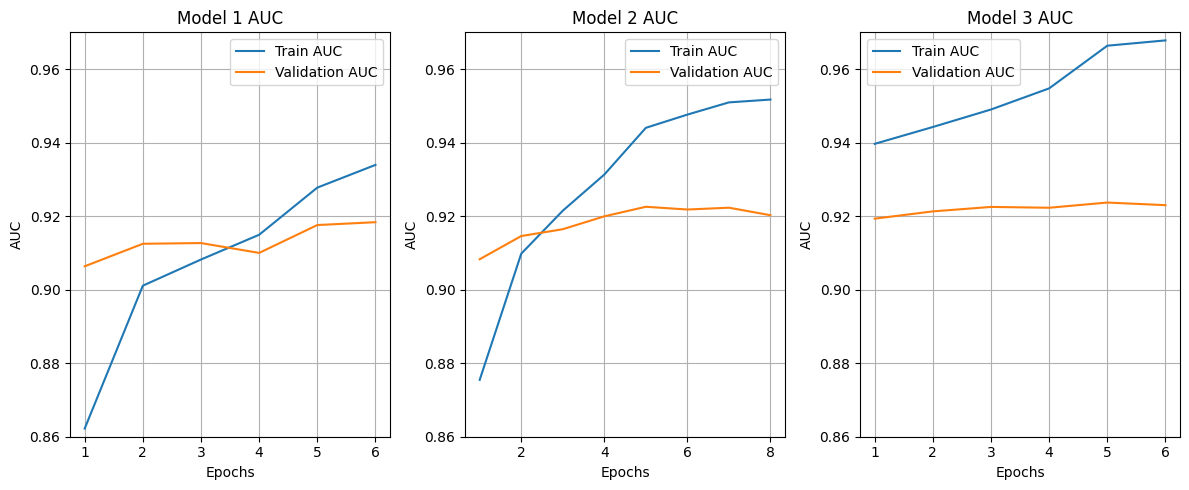

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# plot first model AUC train vs val
ax1.plot(range(1, len(history.history['auc']) + 1), history.history['auc'], label='Train AUC')
ax1.plot(range(1, len(history.history['val_auc']) + 1), history.history['val_auc'], label='Validation AUC')
ax1.set_title('Model 1 AUC')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC')
ax1.legend()
ax1.grid(True)

# plot second model AUC train vs val
ax2.plot(range(1, len(history2.history['auc_3']) + 1), history2.history['auc_3'], label='Train AUC')
ax2.plot(range(1, len(history2.history['val_auc_3']) + 1), history2.history['val_auc_3'], label='Validation AUC')
ax2.set_title('Model 2 AUC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.legend()
ax2.grid(True)

# plot third model AUC train vs val
ax3.plot(range(1, len(history3.history['auc_3']) + 1), history3.history['auc_3'], label='Train AUC')
ax3.plot(range(1, len(history3.history['val_auc_3']) + 1), history3.history['val_auc_3'], label='Validation AUC')
ax3.set_title('Model 3 AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend()
ax3.grid(True)

# set y limits for an equal comparison
ax1.set_ylim(0.86, 0.97)
ax2.set_ylim(0.86, 0.97)
ax3.set_ylim(0.86, 0.97)

plt.tight_layout()
plt.show()

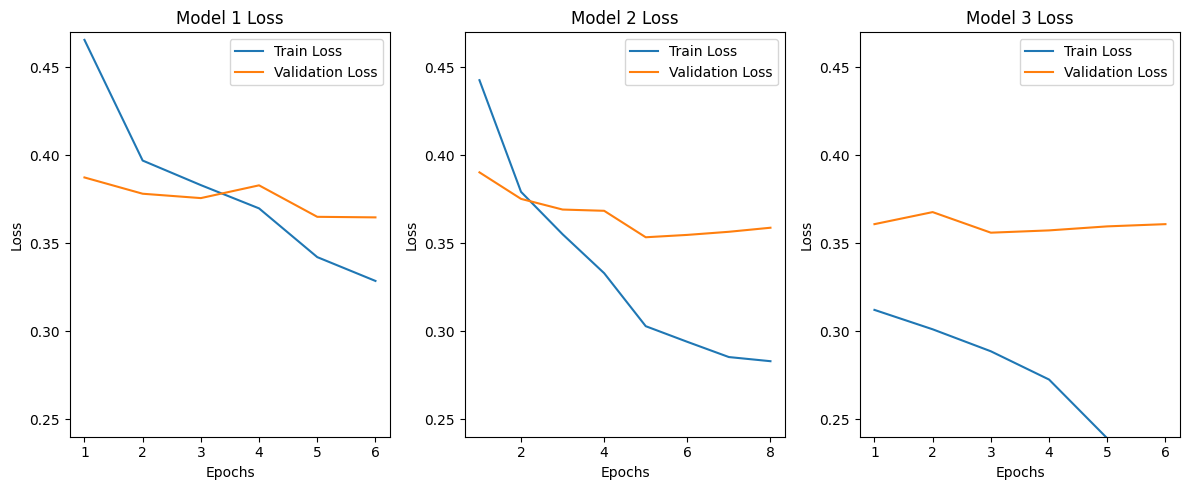

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# plot first model loss train vs val
ax1.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss')
ax1.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model 1 Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot second model loss train vs val
ax2.plot(range(1, len(history2.history['loss']) + 1), history2.history['loss'], label='Train Loss')
ax2.plot(range(1, len(history2.history['val_loss']) + 1), history2.history['val_loss'], label='Validation Loss')
ax2.set_title('Model 2 Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# plot third model loss train vs val
ax3.plot(range(1, len(history3.history['loss']) + 1), history3.history['loss'], label='Train Loss')
ax3.plot(range(1, len(history3.history['val_loss']) + 1), history3.history['val_loss'], label='Validation Loss')
ax3.set_title('Model 3 Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()

# set y limits for an equal comparison
ax1.set_ylim(0.24, 0.47)
ax2.set_ylim(0.24, 0.47)
ax3.set_ylim(0.24, 0.47)

plt.tight_layout()
plt.show()

From these plots, it looks like the third model performed the best with regards to training data, however, validation metrics are going to matter more as we want the model to be able to generalize and perform well on our final test data. We can take a look at these in a table.

In [98]:
# display a table fo the final validation metrics
results = {
    "Model": ["Model 1", "Model 2", "Model 3"],
    "Final Validation AUC": [
        round(history.history['val_auc'][-1], 3),
        round(history2.history['val_auc_3'][-1], 3),
        round(history3.history['val_auc_3'][-1], 3)
    ],
    "Final Validation Loss": [
        round(history.history['val_loss'][-1], 3),
        round(history2.history['val_loss'][-1], 3),
        round(history3.history['val_loss'][-1], 3)
    ]
}

df = pd.DataFrame(results)
print(df)

     Model  Final Validation AUC  Final Validation Loss
0  Model 1                 0.918                  0.365
1  Model 2                 0.920                  0.359
2  Model 3                 0.923                  0.361


Looking at the validation metrics, all the models performed well and fairly similarly. Model 3 does have the highest AUC, which is going to be the final metric in the Kaggle competition. And its validation loss is not that far off from the lowest one. So I've decided to use model 3 as my final model.

Now we can use the model to make predictions on the test data, and create our submission csv.

In [107]:
test_predictions = model3.predict(test_data_gen)

113/113 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step


In [111]:
# get the id's from test_data_gen
filenames = test_data_gen.filenames
image_ids = [filename.split('.')[0] for filename in filenames]  # remove `.tif` extension

# convert predictions from probabilities (sigmoid output) to a flat list
predictions = test_predictions.flatten()

# create a DF with 'id' and 'label' columns
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': predictions
})

# remove test/ from the names
submission_df['id'] = submission_df['id'].apply(lambda x: x.replace('test/', ''))

In [112]:
# save the DF to csv file (without the index column)
submission_df.to_csv('submission.csv', index=False)

## Conclusion

This was my first real project using neural networks so I am pretty happy with my results. I learned a lot about training time and how to set parameters efficiently to reduce training time but keep performance up. Transfer learning turned out to be extremely useful, as there are so many popular models that people use as base models for tasks like image identification. I also learned how to implement learning rate scheduling, which helped reduce training time that may not be that necessary. I also saw the affect of the dropout layer on making a model that can generalize well to data it has never seen before and avoid overfitting. I am really happy this worked out because I was a bit worried about overfitting since I had to use such a small portion of the train data for run time.

For the future I would like to be able to run models with more GPU availability and be able to have more epochs. I'd also be interested in using a common model and freezing everything but the last few layers and retraining only on those. I think this coudl give good results as a lot of research has gone into choosing what each layer is.